In [1]:
from src.Pix2Vox.utils import binvox_rw
import numpy as np
from matplotlib import pyplot as plt
import torch
from scipy.ndimage import zoom
from scipy.signal import resample_poly
from scipy.interpolate import RegularGridInterpolator

In [2]:
def compare_generated(generated_volume, gt_volume, save_path=None):
    generated_volume = generated_volume.squeeze().__ge__(0.5)
    gt_volume = gt_volume.squeeze().__ge__(0.5)

    fig = plt.figure()
    gs = fig.add_gridspec(1, 2)
    ax1, ax2 = fig.add_subplot(gs[0, 0], projection='3d'), fig.add_subplot(gs[0, 1], projection='3d')
    ax1.set_aspect('equal')
    ax1.set_title("Generated")
    ax1.voxels(generated_volume, edgecolor="k")
    ax2.set_aspect('equal')
    ax2.set_title("Ground truth")
    ax2.voxels(gt_volume, edgecolor="k")

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

In [3]:
volume_path = "/home/witold/Cargo/ShapeNetCore.v2/02942699/b42c73b391e14cb16f05a1f780f1cef/models/model_normalized.solid.binvox"
with open(volume_path, 'rb') as f:
    volume = binvox_rw.read_as_3d_array(f)
    volume = volume.data.astype(np.float32)

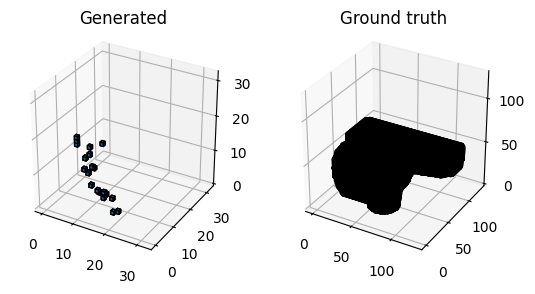

In [4]:
conv = torch.nn.Conv3d(1, 1, 4, 4)
scaled_volume = conv(torch.tensor(volume).unsqueeze(0).unsqueeze(0))
compare_generated(scaled_volume.squeeze().squeeze(), volume)

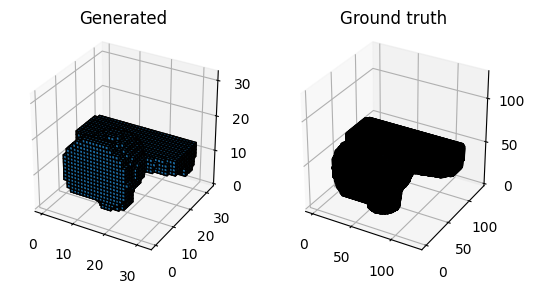

In [5]:
scaled_volume = volume
factors = [(1, 4), (1, 4), (1, 4)]
for k in range(3):
    scaled_volume = resample_poly(scaled_volume, factors[k][0], factors[k][1], axis=k)
compare_generated(scaled_volume, volume)

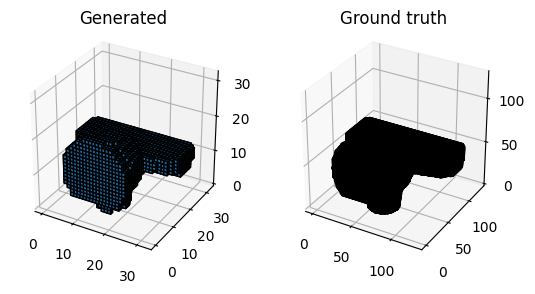

In [6]:
scaled_volume = zoom(volume, (0.25, 0.25, 0.25))
compare_generated(scaled_volume, volume)

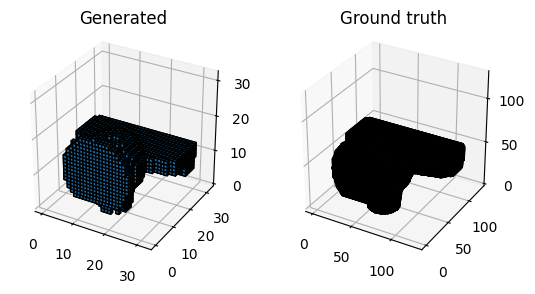

In [7]:
steps = [0.25, 0.25, 0.25]  # original step sizes
x, y, z = [steps[k] * np.arange(volume.shape[k]) for k in range(3)]  # original grid
f = RegularGridInterpolator((x, y, z), volume)  # interpolator

dx, dy, dz = 1.0, 1.0, 1.0  # new step sizes
new_grid = np.mgrid[0:x[-1]:dx, 0:y[-1]:dy, 0:z[-1]:dz]  # new grid
new_grid = np.moveaxis(new_grid, (0, 1, 2, 3), (3, 0, 1, 2))  # reorder axes for evaluation
new_values = f(new_grid)
compare_generated(new_values, volume)

/home/witold/mambaforge-pypy3/envs/machine-perception/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


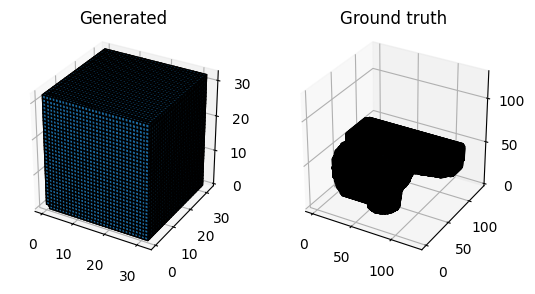

In [8]:
import torch.nn.functional as F

N, C, H, W = 1, 128, 128, 128
x = torch.arange(N * C * H * W).view(N, 1, C, H, W).float()

d = torch.linspace(-1, 1, 32)
meshx, meshy, meshz = torch.meshgrid((d, d, d))
grid = torch.stack((meshx, meshy, meshz), 3)
grid = grid.unsqueeze(0)  # add batch dim

out = F.grid_sample(x, grid, align_corners=True)
compare_generated(out.squeeze().squeeze(), volume)